# Dynamic Time Warping Example

In this notebook, we use the `dtaidistance` package to perform dynamic time warp (DTW) distance measurements of a time series against a reference set of steps. 

We will show that it can be used to identify matches when the distance is low.

In [1]:
import pandas as pd
import json
from dtaidistance import dtw
import numpy as np

Load our reference sequences.

These are stored in json in our label studio output, so will take a little wrangling. The labels give us the endpoints. We use those indexes in the time series data.

In [2]:
reference_file = 'label_studio_export/project-2-at-2025-07-26-03-40-4a2f6183.json'

with open(reference_file,'r') as f:
    ref_data = json.loads(f.read())

In [3]:
ref_data[0]['annotations'][0]['result']

[{'value': {'start': 12.21799754165113,
   'end': 13.456943374825642,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 0',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 10.656723749823868,
   'end': 11.95610654167831,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 1',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 7.836359374923631,
   'end': 8.61195991653949,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 2',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 5.308104874799028,
   'end': 6.103850999847055,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 3',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 16.56942224991

In [4]:
print(ref_data[0]['data']['ts']['acc'][:10])
print(ref_data[0]['data']['ts']['acc_time'][:10])

[1.949547727365608, 2.0866623570923304, 1.067331881776786, 0.6145676606665004, 1.667925843652936, 2.1186010916873315, 2.217205430662157, 1.8256321489476808, 1.2682249329383728, 1.7309814432036563]
[2.517959166551009, 2.5280321666505188, 2.538104166509584, 2.548177166609093, 2.558250166475773, 2.568323166575283, 2.5783951666671783, 2.5884681665338576, 2.5985411666333675, 2.608614166500047]


In [5]:
acc = np.array(ref_data[0]['data']['ts']['acc'])
acc_time = np.array(ref_data[0]['data']['ts']['acc_time'])



In [6]:
annotations = ref_data[0]['annotations'][0]['result']

labels = []
sequences = []

for a in annotations:
    v = a['value']
    start = v['start']
    end = v['end']
    label = v['timeserieslabels'][0] # assume we just have 1 label per region

    # find the indices of start/end in the acc_time series
    start_idx, end_idx = np.where(np.isin(acc_time,[start,end]))[0]

    # store for use in dtaidistance
    labels.append(label)
    sequences.append(acc[start_idx:end_idx+1]) #adding 1 to include the final point



In [7]:
dtw.distance_matrix_fast(sequences)

array([[ 0.        , 22.55507698, 14.4160077 , 13.99295741, 18.81593428,
        18.75307235, 16.08126661, 22.01965365, 31.03693842, 26.93005693,
        29.44099101],
       [22.55507698,  0.        , 20.85140258, 22.5633204 , 21.79343805,
        12.02851814, 23.23088164, 12.19171839, 16.48416246, 18.36203039,
        17.22725814],
       [14.4160077 , 20.85140258,  0.        ,  9.61397487, 12.42909282,
        15.76818528, 10.88019544, 22.1031351 , 26.27397481, 22.42959249,
        24.0117621 ],
       [13.99295741, 22.5633204 ,  9.61397487,  0.        , 13.20096853,
        15.66232715, 12.86661667, 23.37492808, 28.31341555, 26.75986276,
        24.43808819],
       [18.81593428, 21.79343805, 12.42909282, 13.20096853,  0.        ,
        13.78928184, 14.59360823, 20.96607896, 27.30241831, 23.96327223,
        20.4671069 ],
       [18.75307235, 12.02851814, 15.76818528, 15.66232715, 13.78928184,
         0.        , 17.20023918, 15.47697501, 19.39225657, 17.65711067,
        18.540

Load a new sequence we want to search

In [8]:
series_df = pd.read_csv('label_studio/cleese_data.csv')
series = series_df.acc.to_numpy()

In [9]:
# pick a single example to query
query = sequences[0]

(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

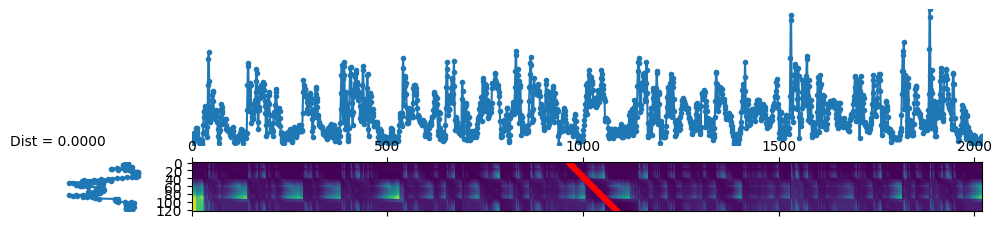

In [10]:
from dtaidistance.subsequence.dtw import subsequence_alignment
from dtaidistance import dtw_visualisation as dtwvis

sa = subsequence_alignment(query, series)
match = sa.best_match()
startidx, endidx = match.segment
dtwvis.plot_warpingpaths(query, series, sa.warping_paths(), match.path)

Distance | Value (dist. normalized by query length)
 0.00000 |  0.00000
 8.21585 |  0.06626
 8.98981 |  0.07250
 9.80984 |  0.07911
10.12346 |  0.08164
10.56568 |  0.08521
10.90047 |  0.08791
11.28920 |  0.09104
11.37649 |  0.09175


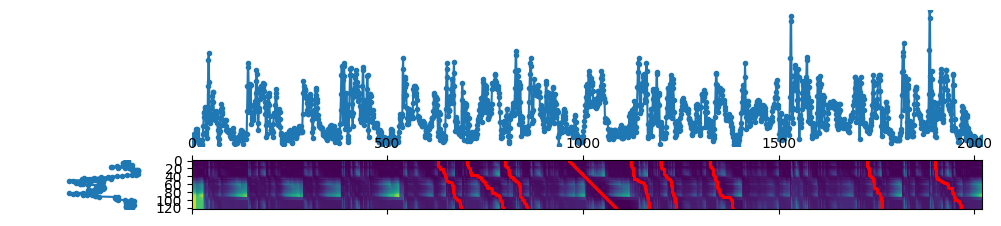

In [14]:
fig, ax = dtwvis.plot_warpingpaths(query, series, sa.warping_paths(), path=-1)
print(f'Distance | Value (dist. normalized by query length)')
for kmatch in sa.kbest_matches_fast(9):
    dtwvis.plot_warpingpaths_addpath(ax, kmatch.path)
    print(f'{kmatch.distance:8.5f} | {kmatch.value:8.5f}')

Try with another reference sequence. We'll see the exact, trivial match (diagonal line), and which ones are similar:

Distance | Value (dist. normalized by query length)
 0.00000 |  0.00000
 8.03704 |  0.10304
 8.25478 |  0.10583
 8.34135 |  0.10694
 8.55281 |  0.10965
 8.76871 |  0.11242
 8.83924 |  0.11332
 9.00374 |  0.11543
 9.10347 |  0.11671


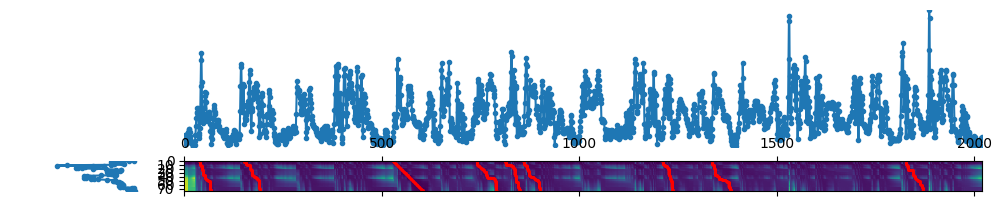

In [15]:
query = sequences[2]
sa = subsequence_alignment(query, series)
fig, ax = dtwvis.plot_warpingpaths(query, series, sa.warping_paths(), path=-1)
print(f'Distance | Value (dist. normalized by query length)')
for kmatch in sa.kbest_matches_fast(9):
    dtwvis.plot_warpingpaths_addpath(ax, kmatch.path)
    print(f'{kmatch.distance:8.5f} | {kmatch.value:8.5f}')

Try the same with a series that does not contain any of this kind of step

In [17]:
series_fwd_df = pd.read_csv('label_studio/forward_walk_data.csv')
series_fwd = series_fwd_df.acc.to_numpy()

13.28603 |  0.10715
677
[np.int64(626), np.int64(677)]
13.82057 |  0.11146
1348
[np.int64(1224), np.int64(1348)]
14.00821 |  0.11297
960
[np.int64(926), np.int64(960)]
14.02753 |  0.11313
1539
[np.int64(1487), np.int64(1539)]
14.81128 |  0.11945
348
[np.int64(317), np.int64(348)]
14.83046 |  0.11960
1182
[np.int64(1142), np.int64(1182)]
16.81767 |  0.13563
595
[np.int64(553), np.int64(595)]
18.68909 |  0.15072
241
[np.int64(191), np.int64(241)]
18.84033 |  0.15194
1091
[np.int64(1033), np.int64(1091)]


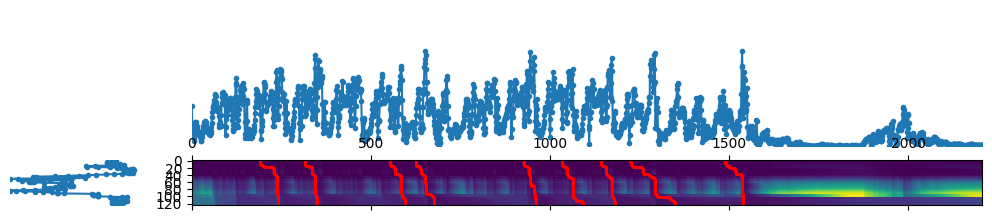

In [18]:
query = sequences[0]
sa = subsequence_alignment(query, series_fwd)
fig, ax = dtwvis.plot_warpingpaths(query, series_fwd, sa.warping_paths(), path=-1)
for kmatch in sa.kbest_matches_fast(9):
    dtwvis.plot_warpingpaths_addpath(ax, kmatch.path)
    print(f'{kmatch.distance:8.5f} | {kmatch.value:8.5f}')
    print(kmatch.idx)
    print(kmatch.segment)